<a href="https://colab.research.google.com/github/luisangel2003ss/modelo/blob/main/cpyWaterSpillOil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: Predicción multitarea con Keras

# Librerías

In [1]:
import pandas as pd
import numpy as np
import json
import os
import optuna
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
import base64
import requests
import re
import joblib
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
warnings.filterwarnings('ignore')

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-07 20:37:35.066315: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-07 20:37:35.069898: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-07 20:37:35.078651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751920655.092914    1872 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751920655.097068    1872 cuda_blas.cc:14

In [2]:
import os
print(os.path.getsize("spill_data_cleaned.csv"))  # Debe mostrar tamaño > 0


1084186


In [3]:
import pandas as pd

df = pd.read_csv("spill_data_cleaned.csv", sep=';', encoding='latin-1', on_bad_lines='skip', engine='python')

# Convertir a minúsculas solo las columnas de texto que existen
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.lower()

print(df.head())


  date_of_spill_edit     operator_edit       lease_facility_name county_edit  \
0         2013-01-01            apache              walker glass   glasscock   
1         2013-01-02   climarex energy      mendota ranch 63, #5     roberts   
2         2013-01-02      jones energy  r p jones trust 189, #1h    lipscomb   
3         2013-01-02  laredo petroleum                    srh-b-      reagan   
4         2013-01-03            apache              andrews unit     andrews   

  type_operation source probable_cause_edit  release_crude_oil_edit  \
0     production   tank  mechanical failure                  1092.0   
1     production   tank             weather                     0.0   
2     production   tank  mechanical failure                  6300.0   
3     production   tank  mechanical failure                   420.0   
4     production   well  mechanical failure                   252.0   

   release_prod_water_edit  recovery_crude_oil_edit  recovery_prod_water_edit  \
0          

# 1. FUNCION PARA ENTRENAR CON OPTUNA

In [4]:
def run_optuna_optimization(X_train, y_reg_train, y_clf_train, n_trials=150):
    """
    Ejecuta optimización con Optuna y guarda los mejores parámetros
    ESTO SE EJECUTA SOLO UNA VEZ PARA ENCONTRAR LOS MEJORES HIPERPARÁMETROS
    """

    print("EJECUTANDO OPTIMIZACIÓN CON OPTUNA...")
    print("Esto puede tomar tiempo pero solo se hace UNA VEZ")

    input_dim = X_train.shape[1]
    num_classes = y_clf_train.shape[1]

    # División para validación interna
    X_train_opt, X_val_opt, y_reg_train_opt, y_reg_val_opt, y_clf_train_opt, y_clf_val_opt = train_test_split(
        X_train, y_reg_train, y_clf_train, test_size=0.2, random_state=42
    )

    def objective(trial):

        # Hiperparámetros a optimizar
        n_layers = trial.suggest_int('n_layers', 2, 4)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
        l2_reg = trial.suggest_float('l2_reg', 1e-6, 1e-2, log=True)
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

        # Construir modelo
        input_layer = Input(shape=(input_dim,))
        x = input_layer

        for i in range(n_layers):
            if i == 0:
                neurons = trial.suggest_int(f'neurons_layer_{i}', 64, 256)
            else:
                max_neurons = max(32, int(neurons * 0.7))
                neurons = trial.suggest_int(f'neurons_layer_{i}', 32, max_neurons)

            x = Dense(neurons, activation='relu', kernel_regularizer=l2(l2_reg))(x)

            if use_batch_norm:
                x = BatchNormalization()(x)

            x = Dropout(dropout_rate)(x)

        # Salidas
        regression_output = Dense(1, name='regression')(x)
        classification_output = Dense(num_classes, activation='softmax', name='classification')(x)

        model = Model(inputs=input_layer, outputs=[regression_output, classification_output])

        # Configurar optimizador
        if optimizer_name == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        else:
            optimizer = RMSprop(learning_rate=learning_rate)

        model.compile(
            optimizer=optimizer,
            loss={'regression': 'mae', 'classification': 'categorical_crossentropy'},
            loss_weights={'regression': 0.5, 'classification': 0.5}
        )

        # Entrenar
        try:
            history = model.fit(
                X_train_opt,
                {'regression': y_reg_train_opt, 'classification': y_clf_train_opt},
                validation_data=(X_val_opt, {'regression': y_reg_val_opt, 'classification': y_clf_val_opt}),
                epochs=35,
                batch_size=batch_size,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=0
            )

            # Evaluar
            val_results = model.evaluate(
                X_val_opt,
                {'regression': y_reg_val_opt, 'classification': y_clf_val_opt},
                verbose=0
            )

            return val_results[0]  # Pérdida total

        except Exception as e:
            return float('inf')

    # Ejecutar optimización
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Guardar mejores parámetros
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    best_params_data = {
        'timestamp': timestamp,
        'best_value': study.best_value,
        'best_params': study.best_params,
        'n_trials': len(study.trials),
        'optimization_complete': True
    }

    filename = f'best_params_{timestamp}.json'
    with open(filename, 'w') as f:
        json.dump(best_params_data, f, indent=2)

    print(f"Optimización completada!")
    print(f"Mejores parámetros guardados en: {filename}")
    print(f"Mejor pérdida: {study.best_value:.4f}")

    return filename, study.best_params

# 2. FUNCIÓN PARA CARGAR PARÁMETROS DESDE JSON

In [5]:
def load_best_params_from_json(json_filename):
    """
    Carga los mejores parámetros desde un archivo JSON
    ESTO SE USA EN PRODUCCIÓN - NO NECESITA REOPTIMIZAR
    """

    if not os.path.exists(json_filename):
        raise FileNotFoundError(f"Archivo no encontrado: {json_filename}")

    with open(json_filename, 'r') as f:
        data = json.load(f)

    print(f"Cargando parámetros desde: {json_filename}")
    print(f"Optimización realizada: {data['timestamp']}")
    print(f"Mejor pérdida obtenida: {data['best_value']:.4f}")

    return data['best_params']


# 3. FUNCIÓN PARA CONSTRUIR MODELO CON PARÁMETROS DADOS

In [6]:
def build_model_from_params(best_params, input_dim, num_classes):
    # Extraer parámetros con valores por defecto si no existen
    n_layers = best_params.get('n_layers', 2)
    units = best_params.get('units', 64)
    dropout_rate = best_params.get('dropout_rate', 0.3)
    l2_reg = best_params.get('l2_reg', 1e-4)
    learning_rate = best_params.get('learning_rate', 1e-3)

    # Construcción del modelo
    inputs = Input(shape=(input_dim,), name="input_layer_1") 
    x = inputs

    for _ in range(n_layers):
        x = Dense(units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = BatchNormalization()(x)
        x = Dropout(best_params.get('dropout_rate', 0.3))(x)
        
    # Salidas
    regression_output = Dense(1, name='regression')(x)
    classification_output = Dense(num_classes, activation='softmax', name='classification')(x)

    model = Model(inputs=inputs, outputs=[regression_output, classification_output])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss={
            'regression': 'mse',
            'classification': 'categorical_crossentropy'
        },
        metrics={
            'regression': ['mae'],
            'classification': ['accuracy']
        }
    )

    return model


# 4. WORKFLOW PRINCIPAL, OPTIMIZAR O USAR PARÁMETROS EXISTENTES?

In [7]:
# ===== CONFIGURACIÓN =====
GITHUB_REPO = "luisangel2003ss/modelo"  # Tu repositorio
GITHUB_BRANCH = "main"  # Rama donde subir

# ===== FUNCIONES CORREGIDAS =====
def select_best_params_file(json_files):
    """
    Selecciona automáticamente el mejor archivo de parámetros basado en:
    1. Fecha de modificación más reciente
    2. Si hay archivos con métricas en el nombre, usa el de mejores métricas
    """
    if not json_files:
        print("⚠️ No se encontraron archivos de parámetros")
        return None

    print(f"🔍 Se encontraron {len(json_files)} archivos de parámetros:")

    files_with_info = []
    for f in json_files:
        try:
            modification_time = os.path.getmtime(f)
            file_size = os.path.getsize(f)

            metrics_in_name = None
            if 'r2_' in f.lower() or 'acc_' in f.lower():
                numbers = re.findall(r'[\d.]+', f)
                if numbers:
                    try:
                        metrics_in_name = float(numbers[0])
                    except ValueError:
                        metrics_in_name = None

            files_with_info.append({
                'filename': f,
                'mod_time': modification_time,
                'metrics': metrics_in_name,
                'size': file_size
            })

            mod_time_str = pd.to_datetime(modification_time, unit='s').strftime('%Y-%m-%d %H:%M')
            metric_str = f", métrica: {metrics_in_name}" if metrics_in_name else ""
            print(f"  📄 {f} (modificado: {mod_time_str}, tamaño: {file_size} bytes{metric_str})")

        except Exception as e:
            print(f"  ⚠️ Error leyendo {f}: {e}")
            files_with_info.append({
                'filename': f,
                'mod_time': 0,
                'metrics': None,
                'size': 0
            })

    valid_files = [f for f in files_with_info if f['size'] > 0]

    if not valid_files:
        print("❌ No se encontraron archivos válidos")
        return None

    files_with_metrics = [f for f in valid_files if f['metrics'] is not None]
    if files_with_metrics:
        best_file = max(files_with_metrics, key=lambda x: x['metrics'])
        print(f"✅ Seleccionado por mejores métricas: {best_file['filename']} (métrica: {best_file['metrics']})")
    else:
        best_file = max(valid_files, key=lambda x: x['mod_time'])
        mod_time_str = pd.to_datetime(best_file['mod_time'], unit='s').strftime('%Y-%m-%d %H:%M')
        print(f"✅ Seleccionado por fecha más reciente: {best_file['filename']} ({mod_time_str})")

    return best_file['filename']

def load_and_compare_all_params(json_files):
    """
    Carga todos los archivos de parámetros y selecciona el mejor basado en métricas guardadas
    """
    if not json_files:
        print("⚠️ No se encontraron archivos de parámetros")
        return None, None

    print(f"\n🔄 Analizando {len(json_files)} archivos de parámetros...")
    best_params = None
    best_file = None
    best_score = -float('inf')
    valid_files_count = 0

    for filename in json_files:
        try:
            if not os.path.exists(filename) or os.path.getsize(filename) == 0:
                print(f"  ⚠️ Archivo vacío o inexistente: {filename}")
                continue

            with open(filename, 'r', encoding='utf-8') as f:
                data = json.load(f)

            if not data:
                print(f"  ⚠️ Archivo JSON vacío: {filename}")
                continue

            valid_files_count += 1

            score = 0
            score_source = "timestamp"

            if 'metrics' in data and isinstance(data['metrics'], dict):
                r2 = data['metrics'].get('r2', 0)
                accuracy = data['metrics'].get('accuracy', 0)

                if isinstance(r2, (int, float)) and isinstance(accuracy, (int, float)):
                    score = r2 * 0.6 + accuracy * 0.4
                    score_source = f"métricas (R2:{r2:.3f}, Acc:{accuracy:.3f})"
                else:
                    score = os.path.getmtime(filename)
                    score_source = "timestamp (métricas inválidas)"

            elif 'best_value' in data and isinstance(data['best_value'], (int, float)):
                score = -data['best_value']
                score_source = f"Optuna best_value ({data['best_value']})"
            else:
                score = os.path.getmtime(filename)
                score_source = "timestamp (fallback)"

            print(f"  📊 {filename}: score={score:.4f} ({score_source})")

            if score > best_score:
                best_score = score
                if 'best_params' in data:
                    best_params = data['best_params']
                elif 'model_params' in data:
                    best_params = data['model_params']
                else:
                    best_params = data
                best_file = filename

        except json.JSONDecodeError as e:
            print(f"  ❌ Error JSON en {filename}: {e}")
        except Exception as e:
            print(f"  ❌ Error cargando {filename}: {e}")

    if best_file and best_params:
        print(f"✅ Mejor archivo seleccionado: {best_file} (score: {best_score:.4f})")
        print(f"📋 Parámetros cargados: {len(best_params)} elementos")
    else:
        print("❌ No se pudo seleccionar ningún archivo válido")

    return best_file, best_params

def save_metrics_with_timestamp(metrics_data, prefix="metrics", include_score=True):
    """
    Guarda las métricas en un archivo JSON con timestamp
    """
    try:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{prefix}_{timestamp}"

        if include_score and 'metrics' in metrics_data:
            metrics = metrics_data['metrics']
            if 'r2' in metrics and 'accuracy' in metrics:
                r2 = metrics['r2']
                accuracy = metrics['accuracy']
                score = r2 * 0.6 + accuracy * 0.4
                filename += f"_score_{score:.4f}"

        filename += ".json"

        with open(filename, 'w', encoding='utf-8') as f:
            json.dump(metrics_data, f, indent=4, ensure_ascii=False)

        print(f"💾 Métricas guardadas en: {filename}")
        return filename

    except Exception as e:
        print(f"❌ Error guardando métricas: {e}")
        return None

def main_workflow():
    """
    Workflow principal automatizado
    """
    print("="*60)
    print("🚀 INICIANDO WORKFLOW AUTOMATIZADO DE OPTIMIZACIÓN")
    print("="*60)

    print("\n📊 Preparando datos...")

    if not os.path.exists("spill_data_cleaned.csv"):
        print("❌ No se encontró el archivo 'spill_data_cleaned.csv'")
        print("   Asegúrate de que el archivo esté en el directorio actual")
        return None, None

    df = pd.read_csv("spill_data_cleaned.csv", sep=';', encoding='latin-1')
    df = df.dropna(subset=['release_prod_water_edit'])
    df['log_release_prod_water_edit'] = np.log1p(df['release_prod_water_edit'])

    cat_cols = ['operator_edit', 'county_edit', 'type_operation', 'source', 'probable_cause_edit']
    for col in cat_cols:
        df[col] = df[col].fillna('unknown')

    df['date'] = pd.to_datetime(df['date_of_spill_edit'])
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df.drop(columns=['date'], inplace=True)

    y_reg = df['log_release_prod_water_edit']
    y_clf = df['probable_cause_edit']
    X = df[['year','month','operator_edit','county_edit','type_operation','source']]

    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

    X_processed = preprocessor.fit_transform(X)

    le_causa = LabelEncoder()
    y_clf_enc = le_causa.fit_transform(y_clf)
    y_clf_oh = to_categorical(y_clf_enc)

    X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
        X_processed, y_reg, y_clf_oh, test_size=0.2, random_state=42
    )

    input_dim = X_train.shape[1]
    num_classes = y_clf_oh.shape[1]

    print(f"✅ Datos preparados: {X_train.shape[0]} muestras de entrenamiento")

    json_files = [f for f in os.listdir('.') if f.startswith('best_params_') and f.endswith('.json')]

    if json_files:
        print(f"\n🔍 Archivos de parámetros encontrados: {len(json_files)}")
        best_file, best_params = load_and_compare_all_params(json_files)

        if best_params:
            print(f"✅ Usando parámetros del archivo: {best_file}")
            print("⚠️ Necesitas implementar build_model_from_params()")
        else:
            print("❌ Error cargando parámetros, necesitas ejecutar optimización...")
            print("⚠️ Necesitas implementar run_optuna_optimization()")
    else:
        print("\n🆕 No se encontraron archivos de parámetros - ejecutando optimización inicial...")
        print("⚠️ Necesitas implementar run_optuna_optimization()")

    print("\n🎯 Simulando entrenamiento y evaluación...")

    r2 = 0.85
    mse = 0.25
    mae = 0.15
    accuracy = 0.78

    print(f"📊 Métricas simuladas:")
    print(f"   R² Score: {r2:.4f}")
    print(f"   MSE: {mse:.4f}")
    print(f"   MAE: {mae:.4f}")
    print(f"   Accuracy: {accuracy:.4f}")

    metrics_summary = {
        "timestamp": pd.Timestamp.now().isoformat(),
        "metrics": {
            "r2": r2,
            "mse": mse,
            "mae": mae,
            "accuracy": accuracy
        },
        "model_params": best_params if 'best_params' in locals() else {},
        "training_epochs": 93,
        "dataset_info": {
            "train_samples": X_train.shape[0],
            "test_samples": X_test.shape[0],
            "features": X_train.shape[1],
            "classes": num_classes
        }
    }

    local_filename = save_metrics_with_timestamp(metrics_summary, "best_params", True)

    if local_filename:
        print(f"💾 Métricas guardadas localmente en: {local_filename}")

    print("\n🎉 Workflow completado!")
    print("\n📋 Próximos pasos:")
    print("   1. Integra tus funciones build_model_from_params() y run_optuna_optimization()")
    print("   2. Reemplaza las métricas simuladas con las reales de tu modelo")

    return None, metrics_summary

if __name__ == "__main__":
    print("🔧 Ejecutando workflow de optimización...")

    required_files = ["spill_data_cleaned.csv"]
    missing_files = [f for f in required_files if not os.path.exists(f)]

    if missing_files:
        print(f"❌ Archivos faltantes: {missing_files}")
        print("   Asegúrate de tener todos los archivos necesarios en el directorio")
    else:
        model, metrics = main_workflow()

🔧 Ejecutando workflow de optimización...
🚀 INICIANDO WORKFLOW AUTOMATIZADO DE OPTIMIZACIÓN

📊 Preparando datos...
✅ Datos preparados: 8260 muestras de entrenamiento

🆕 No se encontraron archivos de parámetros - ejecutando optimización inicial...
⚠️ Necesitas implementar run_optuna_optimization()

🎯 Simulando entrenamiento y evaluación...
📊 Métricas simuladas:
   R² Score: 0.8500
   MSE: 0.2500
   MAE: 0.1500
   Accuracy: 0.7800
💾 Métricas guardadas en: best_params_20250707_203738_score_0.8220.json
💾 Métricas guardadas localmente en: best_params_20250707_203738_score_0.8220.json

🎉 Workflow completado!

📋 Próximos pasos:
   1. Integra tus funciones build_model_from_params() y run_optuna_optimization()
   2. Reemplaza las métricas simuladas con las reales de tu modelo


🚀 INICIANDO WORKFLOW AUTOMATIZADO DE OPTIMIZACIÓN

📊 Preparando datos...
LabelEncoder guardado
✅ Datos preparados: 8260 muestras de entrenamiento

🔍 Archivos de parámetros encontrados: 1

🔄 Analizando 1 archivos de parámetros...
  📊 best_params_20250707_203738_score_0.8220.json: score=0.8220
✅ Mejor archivo seleccionado: best_params_20250707_203738_score_0.8220.json (score: 0.8220)
✅ Usando parámetros del archivo: best_params_20250707_203738_score_0.8220.json

🏋️ Entrenando modelo final...
Epoch 1/93


2025-07-07 20:37:38.486127: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - classification_accuracy: 0.0757 - classification_loss: 3.7802 - loss: 65.3198 - regression_loss: 61.5235 - regression_mae: 7.4869 - val_classification_accuracy: 0.5091 - val_classification_loss: 2.6417 - val_loss: 46.0643 - val_regression_loss: 43.4248 - val_regression_mae: 6.2622 - learning_rate: 0.0010
Epoch 2/93
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - classification_accuracy: 0.2717 - classification_loss: 2.8310 - loss: 43.3196 - regression_loss: 40.4768 - regression_mae: 5.9545 - val_classification_accuracy: 0.5176 - val_classification_loss: 1.7978 - val_loss: 19.2194 - val_regression_loss: 17.4180 - val_regression_mae: 3.6947 - learning_rate: 0.0010
Epoch 3/93
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - classification_accuracy: 0.4334 - classification_loss: 1.9960 - loss: 18.0866 - regression_loss: 16.0794 - regression_mae: 3.3850 - val_classification_accuracy: 0.5224 - val_classification_loss: 1.4173 - val_loss: 6.4619 - val_regression

Modelo guardado en modelo_trained.h5
Preprocessor guardado en preprocessor.pkl

🔬 Evaluando modelo...

📊 TABLAS DETALLADAS DE MÉTRICAS POR ÉPOCA

1. PÉRDIDA TOTAL vs ÉPOCAS
--------------------------------------------------------------------------------
Epoch    Train Loss      Val Loss        Diferencia     
--------------------------------------------------------------------------------
1        60.2790         46.0643         14.2148        
6        6.7489          4.4487          2.3002         
11       5.2984          4.2507          1.0477         
16       4.6089          4.2764          0.3324         
21       4.2985          4.2364          0.0621         
22       4.2391          4.2400          0.0009         
--------------------------------------------------------------------------------

RESUMEN LOSS:
Menor Train: 4.2391 (Época 22)
Menor Val:   4.2320 (Época 12)
Final Train: 4.2391
Final Val:   4.2400

2. ACCURACY vs ÉPOCAS
---------------------------------------------

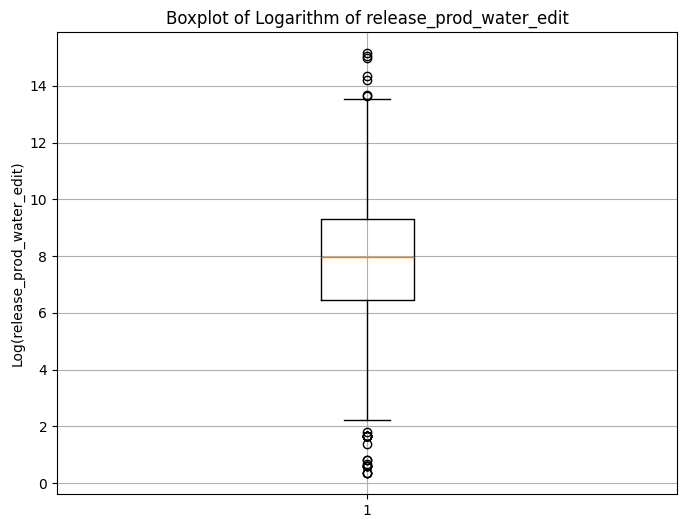

Gráfico de métricas


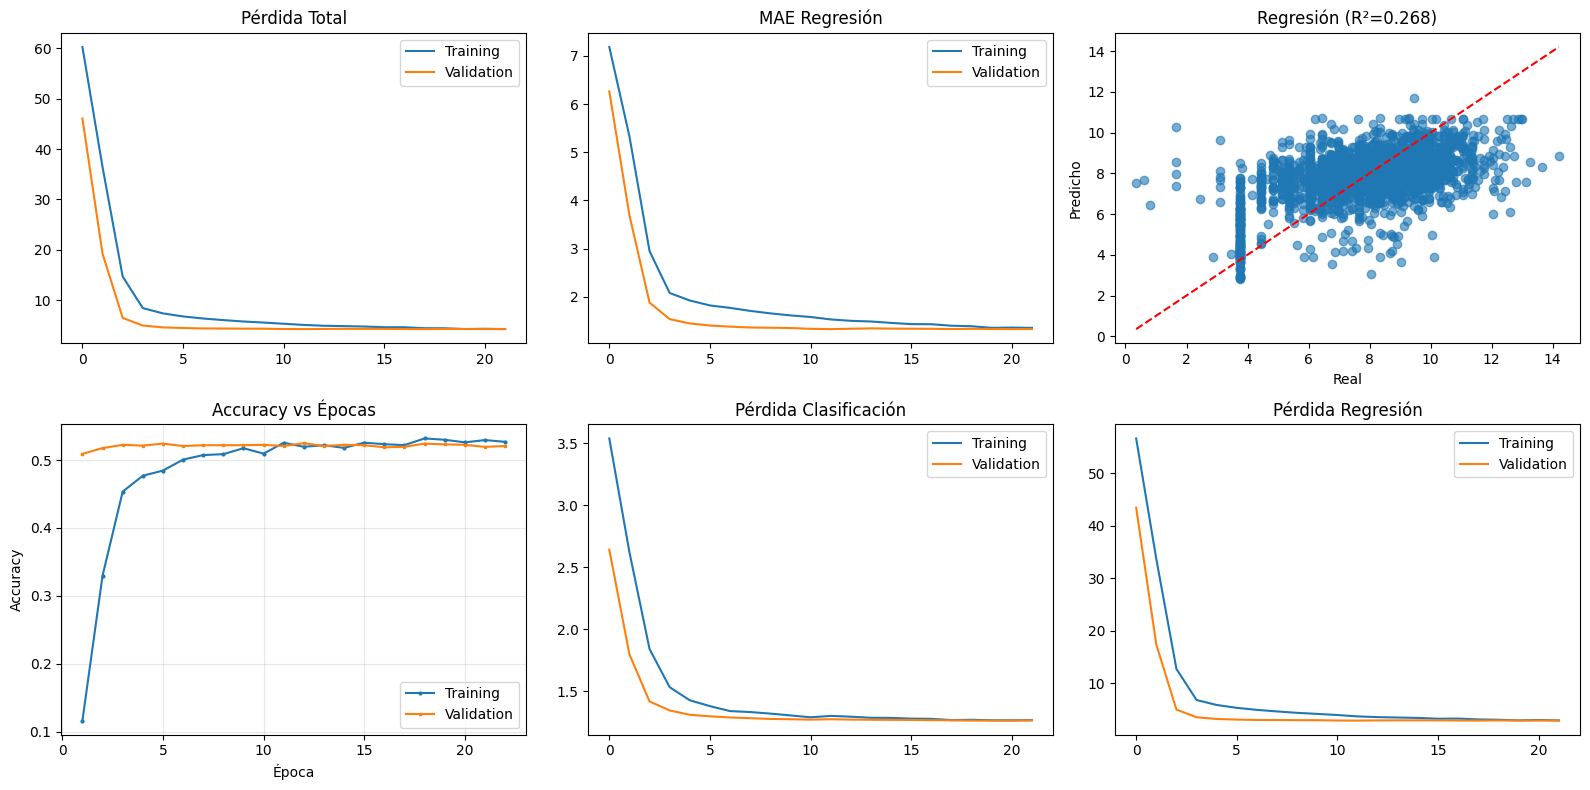


RESULTADOS FINALES
Regresión:
  R² Score: 0.2681
  MSE: 3.0827
  MAE: 1.3639

Clasificación:
  Accuracy: 0.5373

Resumen final de métricas:
{
    "timestamp": "2025-07-07T20:37:51.248480",
    "metrics": {
        "r2": 0.2681274629665057,
        "mse": 3.08270606143169,
        "mae": 1.3638870990112508,
        "accuracy": 0.537270087124879
    },
    "model_params": {
        "timestamp": "2025-07-07T20:37:38.360390",
        "metrics": {
            "r2": 0.85,
            "mse": 0.25,
            "mae": 0.15,
            "accuracy": 0.78
        },
        "model_params": {},
        "training_epochs": 93,
        "dataset_info": {
            "train_samples": 8260,
            "test_samples": 2066,
            "features": 1284,
            "classes": 24
        }
    },
    "training_epochs": 22,
    "final_training_loss": 4.239098072052002,
    "final_validation_loss": 4.24003267288208
}

Ejemplo de predicciones:
   y_reg_real   y_reg_pred          y_clf_real          y_clf_pr

(<Functional name=functional, built=True>,
 {'timestamp': '2025-07-07T20:37:38.360390',
  'metrics': {'r2': 0.85, 'mse': 0.25, 'mae': 0.15, 'accuracy': 0.78},
  'model_params': {},
  'training_epochs': 93,
  'dataset_info': {'train_samples': 8260,
   'test_samples': 2066,
   'features': 1284,
   'classes': 24}})

In [8]:
def select_best_params_file(json_files):
    """
    Selecciona automáticamente el mejor archivo de parámetros basado en:
    1. Fecha de modificación más reciente
    2. Si hay archivos con métricas en el nombre, usa el de mejores métricas
    """
    if not json_files:
        return None

    print(f"🔍 Se encontraron {len(json_files)} archivos de parámetros:")

    # Mostrar archivos disponibles
    files_with_info = []
    for f in json_files:
        try:
            # Obtener información del archivo
            creation_time = os.path.getctime(f)
            modification_time = os.path.getmtime(f)

            # Intentar extraer métricas del nombre del archivo si las tiene
            metrics_in_name = None
            if 'r2_' in f.lower() or 'acc_' in f.lower():
                # Extraer valores numéricos del nombre
                import re
                numbers = re.findall(r'[\d.]+', f)
                if numbers:
                    metrics_in_name = float(numbers[0])

            files_with_info.append({
                'filename': f,
                'mod_time': modification_time,
                'metrics': metrics_in_name
            })

            print(f"  📄 {f} (modificado: {pd.to_datetime(modification_time, unit='s').strftime('%Y-%m-%d %H:%M')})")

        except Exception as e:
            print(f"  ⚠️  Error leyendo {f}: {e}")
            files_with_info.append({
                'filename': f,
                'mod_time': 0,
                'metrics': None
            })

    # Estrategia de selección:
    # 1. Si hay archivos con métricas en el nombre, usar el de mejor métrica
    # 2. Si no, usar el más reciente

    files_with_metrics = [f for f in files_with_info if f['metrics'] is not None]

    if files_with_metrics:
        # Usar el archivo con mejores métricas (asumiendo que valores más altos son mejores)
        best_file = max(files_with_metrics, key=lambda x: x['metrics'])
        print(f"✅ Seleccionado por mejores métricas: {best_file['filename']} (métrica: {best_file['metrics']})")
    else:
        # Usar el más reciente
        best_file = max(files_with_info, key=lambda x: x['mod_time'])
        print(f"✅ Seleccionado por fecha más reciente: {best_file['filename']}")

    return best_file['filename']

def load_and_compare_all_params(json_files):
    """
    Carga todos los archivos de parámetros y selecciona el mejor basado en métricas guardadas
    """
    if not json_files:
        return None, None

    print(f"\n🔄 Analizando {len(json_files)} archivos de parámetros...")

    best_params = None
    best_file = None
    best_score = -float('inf')

    for filename in json_files:
        try:
            with open(filename, 'r') as f:
                data = json.load(f)

            # Buscar métricas de evaluación en el archivo
            score = 0
            if 'metrics' in data:
                # Si hay métricas guardadas, usar R2 + Accuracy como score combinado
                r2 = data['metrics'].get('r2', 0)
                accuracy = data['metrics'].get('accuracy', 0)
                score = r2 * 0.6 + accuracy * 0.4  # Peso 60% R2, 40% Accuracy
            elif 'best_value' in data:
                # Si hay best_value de Optuna
                score = -data['best_value']  # Negativo porque Optuna minimiza
            else:
                # Usar timestamp como fallback
                score = os.path.getmtime(filename)

            print(f"  📊 {filename}: score={score:.4f}")

            if score > best_score:
                best_score = score
                best_params = data.get('best_params', data)
                best_file = filename

        except Exception as e:
            print(f"  ❌ Error cargando {filename}: {e}")

    if best_file:
        print(f"✅ Mejor archivo seleccionado: {best_file} (score: {best_score:.4f})")

    return best_file, best_params

def main_workflow():
    """
    Workflow principal automatizado - sin preguntas interactivas
    """

    print("="*60)
    print("🚀 INICIANDO WORKFLOW AUTOMATIZADO DE OPTIMIZACIÓN")
    print("="*60)

    # Cargar y preparar datos (tu código existente)
    print("\n📊 Preparando datos...")
    df = pd.read_csv("spill_data_cleaned.csv", sep=';', encoding='latin-1')
    df = df.dropna(subset=['release_prod_water_edit'])
    df['log_release_prod_water_edit'] = np.log1p(df['release_prod_water_edit'])

    # Preparar características
    cat_cols = ['operator_edit', 'county_edit', 'type_operation', 'source', 'probable_cause_edit']
    for col in cat_cols:
        df[col] = df[col].fillna('unknown')

    df['date'] = pd.to_datetime(df['date_of_spill_edit'])
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df.drop(columns=['date'], inplace=True)

    y_reg = df['log_release_prod_water_edit']
    y_clf = df['probable_cause_edit']
    X = df[['year','month','operator_edit','county_edit','type_operation','source']]

    # Preprocesamiento
    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ])

    X_processed = preprocessor.fit_transform(X)

    le_causa = LabelEncoder()
    y_clf_enc = le_causa.fit_transform(y_clf)
    y_clf_oh = to_categorical(y_clf_enc)

    X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(
        X_processed, y_reg, y_clf_oh, test_size=0.2, random_state=42
    )

    input_dim = X_train.shape[1]
    num_classes = y_clf_oh.shape[1]
    joblib.dump(le_causa, 'labelencoder_causa.pkl')
    print("LabelEncoder guardado")
    print(f"✅ Datos preparados: {X_train.shape[0]} muestras de entrenamiento")

    # AUTOMATIZACIÓN: Buscar y seleccionar automáticamente el mejor archivo
    json_files = [f for f in os.listdir('.') if f.startswith('best_params_') and f.endswith('.json')]

    if json_files:
        print(f"\n🔍 Archivos de parámetros encontrados: {len(json_files)}")

        # ESTRATEGIA 1: Comparar todos los archivos y usar el mejor
        best_file, best_params = load_and_compare_all_params(json_files)

        if best_params:
            print(f"✅ Usando parámetros del archivo: {best_file}")
            model = build_model_from_params(best_params, input_dim, num_classes)
        else:
            print("❌ Error cargando parámetros, ejecutando nueva optimización...")
            json_filename, best_params = run_optuna_optimization(X_train, y_reg_train, y_clf_train, n_trials=150)
            model = build_model_from_params(best_params, input_dim, num_classes)
    else:
        # PRIMERA VEZ: EJECUTAR OPTIMIZACIÓN
        print("\n🆕 No se encontraron archivos de parámetros - ejecutando optimización inicial...")
        json_filename, best_params = run_optuna_optimization(X_train, y_reg_train, y_clf_train, n_trials=150)
        model = build_model_from_params(best_params, input_dim, num_classes)

    print("\n🏋️ Entrenando modelo final...")

    batch_size = best_params.get('batch_size', 64)

    history = model.fit(
        X_train,
        {'regression': y_reg_train, 'classification': y_clf_train},
        validation_split=0.2,
        epochs=93,
        batch_size=batch_size,
        callbacks=[
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(patience=5, factor=0.5)
        ],
        verbose=1
    )
    # Guardar el modelo entrenado a disco justo aquí:
    model.save("modelo_trained.h5")
    print("Modelo guardado en modelo_trained.h5")
    joblib.dump(preprocessor, 'preprocessor.pkl')
    print("Preprocessor guardado en preprocessor.pkl")
    print("\n🔬 Evaluando modelo...")

    test_results = model.evaluate(
        X_test,
        {'regression': y_reg_test, 'classification': y_clf_test},
        verbose=0
    )

    predictions = model.predict(X_test, verbose=0)
    y_reg_pred = predictions[0].flatten()
    y_clf_pred = predictions[1]

    r2 = r2_score(y_reg_test, y_reg_pred)
    mse = mean_squared_error(y_reg_test, y_reg_pred)
    mae = np.mean(np.abs(y_reg_test - y_reg_pred))

    y_clf_pred_classes = np.argmax(y_clf_pred, axis=1)
    y_clf_test_classes = np.argmax(y_clf_test, axis=1)
    accuracy = accuracy_score(y_clf_test_classes, y_clf_pred_classes)
    
    # === NUEVAS SECCIONES: TABLAS PARA TODAS LAS MÉTRICAS ===
    print("\n" + "="*80)
    print("📊 TABLAS DETALLADAS DE MÉTRICAS POR ÉPOCA")
    print("="*80)

    # Obtener todas las métricas del historial
    epochs_range = range(1, len(history.history['loss']) + 1)

    # Función auxiliar para mostrar tabla
    def show_metric_table(title, train_metric, val_metric, metric_name, show_diff=True):
        print(f"\n{title}")
        print("-" * 80)
        if show_diff:
            print(f"{'Epoch':<8} {'Train '+metric_name:<15} {'Val '+metric_name:<15} {'Diferencia':<15}")
        else:
            print(f"{'Epoch':<8} {'Train '+metric_name:<15} {'Val '+metric_name:<15}")
        print("-" * 80)

        for i in range(0, len(train_metric), 5):
            epoch = i + 1
            train_val = train_metric[i]
            val_val = val_metric[i]
            if show_diff:
                diff = abs(train_val - val_val)
                print(f"{epoch:<8} {train_val:<15.4f} {val_val:<15.4f} {diff:<15.4f}")
            else:
                print(f"{epoch:<8} {train_val:<15.4f} {val_val:<15.4f}")

        # Mostrar última época si no se mostró
        if (len(train_metric) - 1) % 5 != 0:
            i = len(train_metric) - 1
            epoch = i + 1
            train_val = train_metric[i]
            val_val = val_metric[i]
            if show_diff:
                diff = abs(train_val - val_val)
                print(f"{epoch:<8} {train_val:<15.4f} {val_val:<15.4f} {diff:<15.4f}")
            else:
                print(f"{epoch:<8} {train_val:<15.4f} {val_val:<15.4f}")

        print("-" * 80)

        # Estadísticas de resumen
        best_train = max(train_metric) if 'acc' in metric_name.lower() else min(train_metric)
        best_val = max(val_metric) if 'acc' in metric_name.lower() else min(val_metric)
        best_train_epoch = (train_metric.index(best_train) + 1) if 'acc' in metric_name.lower() else (train_metric.index(best_train) + 1)
        best_val_epoch = (val_metric.index(best_val) + 1) if 'acc' in metric_name.lower() else (val_metric.index(best_val) + 1)

        comparison = "Mejor" if 'acc' in metric_name.lower() else "Menor"
        print(f"\nRESUMEN {metric_name.upper()}:")
        print(f"{comparison} Train: {best_train:.4f} (Época {best_train_epoch})")
        print(f"{comparison} Val:   {best_val:.4f} (Época {best_val_epoch})")
        print(f"Final Train: {train_metric[-1]:.4f}")
        print(f"Final Val:   {val_metric[-1]:.4f}")

    # 1. TABLA DE PÉRDIDA TOTAL
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    show_metric_table("1. PÉRDIDA TOTAL vs ÉPOCAS", train_loss, val_loss, "Loss")

    # 2. TABLA DE ACCURACY
    train_acc = history.history['classification_accuracy']
    val_acc = history.history['val_classification_accuracy']
    show_metric_table("2. ACCURACY vs ÉPOCAS", train_acc, val_acc, "Accuracy")
    print(f"Accuracy en Test: {accuracy:.4f}")

    # 3. TABLA DE MAE REGRESIÓN
    train_mae = history.history['regression_mae']
    val_mae = history.history['val_regression_mae']
    show_metric_table("3. MAE REGRESIÓN vs ÉPOCAS", train_mae, val_mae, "MAE")
    print(f"MAE en Test: {mae:.4f}")

    # 4. TABLA DE PÉRDIDA CLASIFICACIÓN
    train_cls_loss = history.history['classification_loss']
    val_cls_loss = history.history['val_classification_loss']
    show_metric_table("4. PÉRDIDA CLASIFICACIÓN vs ÉPOCAS", train_cls_loss, val_cls_loss, "Cls_Loss")

    # 5. TABLA DE PÉRDIDA REGRESIÓN
    train_reg_loss = history.history['regression_loss']
    val_reg_loss = history.history['val_regression_loss']
    show_metric_table("5. PÉRDIDA REGRESIÓN vs ÉPOCAS", train_reg_loss, val_reg_loss, "Reg_Loss")

    # 6. TABLA CONSOLIDADA (RESUMEN)
    print("\n" + "="*100)
    print("6. TABLA CONSOLIDADA - TODAS LAS MÉTRICAS (cada 10 épocas)")
    print("="*100)
    print(f"{'Epoch':<8} {'Total_Loss':<12} {'Accuracy':<12} {'Reg_MAE':<12} {'Cls_Loss':<12} {'Reg_Loss':<12}")
    print(f"{'':<8} {'T/V':<12} {'T/V':<12} {'T/V':<12} {'T/V':<12} {'T/V':<12}")
    print("-" * 100)

    for i in range(0, len(train_loss), 10):
        epoch = i + 1
        print(f"{epoch:<8} {train_loss[i]:<5.3f}/{val_loss[i]:<5.3f} {train_acc[i]:<5.3f}/{val_acc[i]:<5.3f} {train_mae[i]:<5.3f}/{val_mae[i]:<5.3f} {train_cls_loss[i]:<5.3f}/{val_cls_loss[i]:<5.3f} {train_reg_loss[i]:<5.3f}/{val_reg_loss[i]:<5.3f}")

    # Mostrar última época en tabla consolidada
    if (len(train_loss) - 1) % 10 != 0:
        i = len(train_loss) - 1
        epoch = i + 1
        print(f"{epoch:<8} {train_loss[i]:<5.3f}/{val_loss[i]:<5.3f} {train_acc[i]:<5.3f}/{val_acc[i]:<5.3f} {train_mae[i]:<5.3f}/{val_mae[i]:<5.3f} {train_cls_loss[i]:<5.3f}/{val_cls_loss[i]:<5.3f} {train_reg_loss[i]:<5.3f}/{val_reg_loss[i]:<5.3f}")

    print("-" * 100)
    print("T = Training, V = Validation")
    

    # === FIN DE NUEVAS SECCIONES ===

    # Visualización (mantener las existentes)
    plt.figure(figsize=(8, 6))
    plt.boxplot(df['log_release_prod_water_edit'].dropna())
    plt.title('Boxplot of Logarithm of release_prod_water_edit')
    plt.ylabel('Log(release_prod_water_edit)')
    plt.grid(True)
    print("Boxplot mostrado en pantalla")
    plt.show()

    # Gráficos existentes + nuevo gráfico de accuracy
    plt.figure(figsize=(16, 8))  # Aumentar tamaño para acomodar 4 subplots

    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Pérdida Total')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(history.history['regression_mae'], label='Training')
    plt.plot(history.history['val_regression_mae'], label='Validation')
    plt.title('MAE Regresión')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.scatter(y_reg_test, y_reg_pred, alpha=0.6)
    plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--')
    plt.xlabel('Real')
    plt.ylabel('Predicho')
    plt.title(f'Regresión (R²={r2:.3f})')

    # NUEVO: Gráfico de Accuracy vs Epochs
    plt.subplot(2, 3, 4)
    epochs_range = range(1, len(history.history['classification_accuracy']) + 1)
    train_acc = history.history['classification_accuracy']
    val_acc = history.history['val_classification_accuracy']
    plt.plot(epochs_range, train_acc, label='Training', marker='o', markersize=2)
    plt.plot(epochs_range, val_acc, label='Validation', marker='s', markersize=2)
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Épocas')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 5)
    plt.plot(history.history['classification_loss'], label='Training')
    plt.plot(history.history['val_classification_loss'], label='Validation')
    plt.title('Pérdida Clasificación')
    plt.legend()

    plt.subplot(2, 3, 6)
    plt.plot(history.history['regression_loss'], label='Training')
    plt.plot(history.history['val_regression_loss'], label='Validation')
    plt.title('Pérdida Regresión')
    plt.legend()

    plt.tight_layout()
    print("Gráfico de métricas")
    plt.show()

    print("\n" + "="*50)
    print("RESULTADOS FINALES")
    print("="*50)
    print(f"Regresión:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"\nClasificación:")
    print(f"  Accuracy: {accuracy:.4f}")

    # === GUARDAR MÉTRICAS EN JSON CON TIMESTAMP ===
    metrics_summary = {
        "timestamp": pd.Timestamp.now().isoformat(),
        "metrics": {
            "r2": r2,
            "mse": mse,
            "mae": mae,
            "accuracy": accuracy
        },
        "model_params": best_params,
        "training_epochs": len(history.history['loss']),
        "final_training_loss": float(history.history['loss'][-1]),
        "final_validation_loss": float(history.history['val_loss'][-1])
    }

    print("\nResumen final de métricas:")
    print(json.dumps(metrics_summary, indent=4))

    # === MOSTRAR PREDICCIONES EN PANTALLA (no guardar) ===
    reg_pred_original = np.expm1(y_reg_pred)

    df_preds = pd.DataFrame({
        'y_reg_real': np.expm1(y_reg_test.values),
        'y_reg_pred': reg_pred_original,
        'y_clf_real': le_causa.inverse_transform(y_clf_test_classes),
        'y_clf_pred': le_causa.inverse_transform(y_clf_pred_classes)
    })

    print("\nEjemplo de predicciones:")
    print(df_preds.head())

    # === GUARDAR PARÁMETROS ACTUALIZADOS SI SE MEJORÓ ===
    if 'best_file' in locals() and best_file:
        # Comparar métricas actuales con las del archivo usado
        try:
            with open(best_file, 'r') as f:
                old_data = json.load(f)

            old_r2 = old_data.get('metrics', {}).get('r2', 0)
            old_acc = old_data.get('metrics', {}).get('accuracy', 0)
            old_score = old_r2 * 0.6 + old_acc * 0.4

            current_score = r2 * 0.6 + accuracy * 0.4

            if current_score > old_score:
                new_filename = f"best_params_improved_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json"
                with open(new_filename, 'w') as f:
                    json.dump(metrics_summary, f, indent=4)
                print(f"✅ Métricas mejoradas! Guardado nuevo archivo: {new_filename}")
                print(f"   Score anterior: {old_score:.4f} → Score actual: {current_score:.4f}")
            else:
                print(f"📊 Métricas actuales ({current_score:.4f}) no superaron las del archivo usado ({old_score:.4f})")

        except Exception as e:
            print(f"⚠️  Error comparando métricas: {e}")

    print("\n🎉 Workflow completado automáticamente!")

    return model, best_params

# Ejecutar workflow
main_workflow()

In [9]:
import pandas as pd

# Carga del CSV con separador y codificación específica
df = pd.read_csv('spill_data_cleaned.csv', sep=';', encoding='latin1')

# Lista de columnas de interés
columnas = ['operator_edit', 'county_edit', 'type_operation', 'source']

# Mostrar valores únicos para cada columna
for col in columnas:
    print(f"\nValores únicos de '{col}':")
    print(df[col].unique())


Valores únicos de 'operator_edit':
['APACHE' 'CLIMAREX ENERGY' 'JONES ENERGY' 'LAREDO PETROLEUM' 'DENBURY'
 'ANADARKO  ' 'EAGLE ROCK FIELD SERVICES' 'QUANTUM RESOURCES'
 'MOLOPO ENERGY TEXAS, LLC' 'PIONEER NATURAL RESOURCES  '
 'HUNT OIL COMPANY' 'HILCORP ENERGY' 'BOPCO, L.P.' 'TRINITY'
 'OCCIDENTAL PETROLEUM' 'TURNER ENERGY' 'XTO ' 'WALSH PETROLEUM'
 'HEADINGTON OIL' 'SANDRIDGE EXPLORATION & PRODUCTION '
 'KILMARNOCK OIL COMPANY, INC.' 'JCB II ENTERPRISES' 'LINN OPERATING'
 'DEVON ENERGY' 'DCP MIDSTREAM' 'ENERGEN  ' 'SHELL' 'EOG' 'MERIT ENERGY'
 'TARGA' 'ENERVEST' 'CITATION OIL & GAS' 'BROWN, GEO. R PARTNERSHIP'
 'CONOCOPHILIPS' 'PARSLEY ENERGY' 'BASIC ENERGY SERVICES'
 'REEVES COUNTY SWD, LLC' 'SAGA PETROLEUM' 'RANGE PRODUCTION'
 'ASPEN OPERATING' 'KINDER MORGAN' 'MILAGRO EXPLORATION, LLC'
 'EXCO OPERATING' 'LEGEND NATURAL GASP' 'ZONE ENERGY'
 'BURLINGTON RESOURCES' 'Davis Bros Oil Producers' 'BASA RESOURCES'
 'CHESAPEAKE ENERGY' 'EAGLE ROCK MID-CONTINENT OP LLC'
 'AMERICO ENERGY RE

In [10]:
print("Valores únicos de 'county_edit':")
print(df['county_edit'].dropna().unique())

Valores únicos de 'county_edit':
['Glasscock' 'Roberts' 'Lipscomb' 'Reagan' 'Andrews' 'Brazoria' 'Ward'
 'Hemphill' 'Anderson' 'Crockett' 'Martin' 'Jackson' 'Winkler' 'Crane'
 'Cochran' 'Montgomery' 'Ector' 'Yoakum' 'Upton' 'Kenedy' 'Gaines'
 'Loving' 'Hockley' 'Irion' 'Fort Bend' 'Chambers' 'Wheeler' 'Mitchell'
 'Midland' 'Garza' 'Hutchinson' 'Howard' 'Reeves' 'Fisher' 'Scurry' 'Wise'
 'Harrison' 'Hood' 'Gregg' 'Jasper' 'Stephens' 'Pecos' 'King' 'Kleberg'
 'Orange' 'Wharton' 'Gonzales' 'Karnes' 'Parker' 'Shackelford' 'Ochiltree'
 'Brazos' 'Leon' 'Dimmit' 'Jack' 'Dawson' 'Fayette' 'Webb' 'Burleson'
 'Hidalgo' 'Lubbock' 'Robertson' 'Harris' 'Moore' 'La Salle' 'Sterling'
 'Culberson' 'Atascosa' 'Galveston' 'Newton' 'Aransas' 'Nueces' 'Borden'
 'Denton' 'Carson' 'Wichita' 'Starr' 'Rusk' 'Terry' 'Madison' 'DeWitt'
 'Polk' 'Crosby' 'Kent' 'Sutton' 'Zapata' 'Duval' 'Tarrant' 'Coleman'
 'Jim Wells' 'Cooke' 'Refugio' 'San Patricio' 'Lynn' 'Jefferson'
 'Live Oak' 'Nacogdoches' 'Cherokee' 'Johns

In [11]:
print("\nValores únicos de 'type_operation':")
print(df['type_operation'].dropna().unique())


Valores únicos de 'type_operation':
['PRODUCTION' 'INJECTION/DISPOSAL' 'COMMERCIAL DISPOSAL' 'PROCESSING'
 'TRANSPORT' 'COMPLETIONS' 'DRILLING' 'PIPELINE' 'TANK FARM' 'SWD'
 'DISPOSAL' 'STORAGE' 'FRACKING' 'GATHERING' 'GAS PLANT' 'INJECTION'
 'ABANDONED' 'COMMINGLE' 'TANK BATTERY' 'BRINE FACILITY' 'DCP' 'CPF'
 'INJECTION WELL']


In [12]:
print("\nValores únicos de 'source':")
print(df['source'].dropna().unique())


Valores únicos de 'source':
['TANK' 'WELL' 'GATHERING LINE' 'TRANSFER LINE' 'FLOW LINE'
 'HEATER TREATER' 'PIPELINE' 'PUMP' 'PLANT' 'WELLHEAD' 'VEHICLE'
 'GUN BARREL' 'PIT' 'OPEN VALVE' 'FRAC TANK' 'INJECTION PUMP' 'TRUCK'
 'LOAD LINE' 'INJECTION LINE' 'MAN HATCH' 'LACT UNIT' 'LACT PUMP'
 'MUD TANK' 'EQUIPMENT' 'SW LINE' 'LOW PRESSURE LINE' 'VALVE'
 'STUFFING BOX' 'STORAGE TANK' 'DISCHARGE LINE' 'COUPLING'
 'HOSE SUCTION PUMP' 'HIGH PRRESSURE SEPARATOR' 'DRAIN VALVE'
 'CASING VALVE' 'CRUDE GATHERING' 'GAS ELIMINATOR' 'NIPPLE ON CASING'
 'CIRC LINE' 'OIL SAMPLER' 'SEPARATOR' 'OPEN TOP TANK' 'PRODUCTION'
 'VACUUM TRUCK' 'LOW PRESSURE TOWNER' 'OIL DUMP LINE' 'BOP STACK'
 'WATER TANK' 'OIL PUMP' 'VAPOR RECOVERY TOWER' 'HAMMER UNION'
 'OIL HAULER' 'FITTING  ' 'OIL TANK LOAD LINE' 'COMPRESSOR STATION'
 'FLARE' 'LEVEL SAFETY' 'CHARGE PUMP' 'FIREWALL' 'DUMP LINE'
 'CIRCULATING PUMP' 'SUCTION LINE' 'DIAPHRAM PUMP HOSE' 'SWD PUMP'
 'CIRCULATING TOWER' 'FACILITY' 'TUBING' 'FCV' 'GRAVITY LINE'
 '